In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cpu,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cpu,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sum, switch,
                           tensor3, tensor5, TensorType, tile, vector)
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing(use_latex='mathjax')

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
from matplotlib.pyplot import (axes, close, contour, contourf, figure,
                               legend, plot, rcParams, show, title,
                               xlabel, ylabel)
from matplotlib.cm import * #coolwarm, Spectral, etc.
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select
# E.g. select({3:3.2,2:2.2})[[2,3]] or
S=select({3:3.2,2:2.2})
S[array([2,3,2,2])]

array([ 2.2,  3.2,  2.2,  2.2])

In [10]:
from smatrix import *
# E.g.
print matrix([[1,2],[3,4]]).inverse()

-2   1

 1  -1


In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    try: # theano?
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    except:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world.

In [12]:
dim = range(1) # dimension
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

#### Boundary Conditions

We introduce fictitious worlds, two worlds deep, at the edges of the array to represent boundary conditions. Boundry worlds can be removed or set to zero.

In [13]:
B=2
def boundary0(r):
    for i in range(r.ndim):
        rs = list(r.shape); rs[i]=1
        s = [1]*r.ndim; s[i]=B
        before1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        s = [1]*r.ndim; s[i]=B
        after1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        r = concatenate([before1,r,after1], axis=i)
    return r

In [14]:
def boundary(s): return stack([boundary0(r) for r in s])

In [15]:
def debound(r): return r[tuple([slice(B,-B)]*(r.ndim))]

In [16]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

In [17]:
# E.g.
grid(2,2)

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

In [18]:
boundary(grid(2,2)).eval()

array([[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.25,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.75,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]])

In [19]:
array(map(debound,boundary(grid(2,2)).eval()))

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

### Difference operator ###

In [20]:
# In the following use numpy's roll and stack. Later we will use theano for these operations.
from numpy import roll, stack

In [21]:
N=9

In [22]:
s=array(meshgrid(*[symbols(['x_{%s}'%(str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)]) for j in dim],indexing='ij'))

In [23]:
list(s[0,:])

[x_{i-4}, x_{i-3}, x_{i-2}, x_{i-1}, x_{i}, x_{i+1}, x_{i+2}, x_{i+3}, x_{i+4}
]

In [24]:
# names for sympy variables
[xm4,xm3,xm2,xm1,x_i,x1,x2,x3,x4] = list(s[0,:])

In [25]:
x_i # index of i'th world

x_{i}

The index of the $i^{th}$ world with boundry worlds removed:

In [26]:
ith = N//2-B

In [27]:
debound(s[0])[ith]

x_{i}

Forward and backward differences

In [28]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

In [29]:
list(debound(d(+1,s[0],0)))

[x_{i-2} - x_{i-3}, x_{i-1} - x_{i-2}, -x_{i-1} + x_{i}, x_{i+1} - x_{i}, -x_{
i+1} + x_{i+2}]

In [30]:
list(debound(d(-1,s[0],0)))

[x_{i-1} - x_{i-2}, -x_{i-1} + x_{i}, x_{i+1} - x_{i}, -x_{i+1} + x_{i+2}, -x_
{i+2} + x_{i+3}]

Jacobian

In [31]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [32]:
def K(C): return 1/J(C)

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [33]:
def Q(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim]))

In [34]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
list(mu)

[μ₀]

In [35]:
hbar=Symbol('hbar')

The quantum potential at the $i^{th}$ world:

In [36]:
Qs=Q(hbar,mu,s)

In [37]:
Qs[ith]

     ⎛                                      2                                 
     ⎜⎛         1                  1       ⎞           1                  2   
     ⎜⎜- ──────────────── + ───────────────⎟    ──────────────── - ───────────
   2 ⎜⎝  -x_{i-1} + x_{i}   x_{i+1} - x_{i}⎠    -x_{i-1} + x_{i}   x_{i+1} - x
-h̅ ⋅⎜─────────────────────────────────────── + ──────────────────────────────
     ⎝                   2                                          x_{i+1} - 
──────────────────────────────────────────────────────────────────────────────
                                                   4⋅μ₀                       

                         ⎞ 
               1         ⎟ 
──── + ──────────────────⎟ 
_{i}   -x_{i+1} + x_{i+2}⎟ 
─────────────────────────⎟ 
x_{i}                    ⎠ 
───────────────────────────
                           

#### Quantum Force ####

In general the force is a vector.
Provided the number of worlds is large enough the trace of Q contains sufficient information to compute gradients.

In [38]:
QU=add(Qs) # trace in 1-d

In [39]:
R0 = -QU.diff(x_i); R0

                                                                              
    ⎛           1                  1                                          
    ⎜  - ─────────────── + ──────────────────                                 
  2 ⎜    x_{i+1} - x_{i}   -x_{i+1} + x_{i+2}                      1          
h̅ ⋅⎜- ────────────────────────────────────── + ──────────────────────────────
    ⎜                             2                                           
    ⎝            (x_{i+1} - x_{i})              (-x_{i+1} + x_{i+2})⋅(x_{i+1} 
──────────────────────────────────────────────────────────────────────────────
                                          4⋅μ₀                                
                                                                              

                 ⎛         2                    1                             
         ⎞       ⎜─────────────────── + ──────────────────             1      
         ⎟       ⎜                  2              

 Schiff & Poirier eq 18

In [40]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([debound(add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim]))
            for i in dim])

In [41]:
Rs=R(hbar,mu,s); Rs[0,ith]

    ⎛          1                  2                  1                 1      
    ⎜  ───────────────── - ──────────────── + ───────────────   ──────────────
  2 ⎜  x_{i-1} - x_{i-2}   -x_{i-1} + x_{i}   x_{i+1} - x_{i}   -x_{i-1} + x_{
h̅ ⋅⎜- ────────────────────────────────────────────────────── + ──────────────
    ⎜                                     2                                   
    ⎝                   (-x_{i-1} + x_{i})                                    
──────────────────────────────────────────────────────────────────────────────
                                                          4⋅μ₀                

            2                  1         ⎞
── - ─────────────── + ──────────────────⎟
i}   x_{i+1} - x_{i}   -x_{i+1} + x_{i+2}⎟
─────────────────────────────────────────⎟
                      2                  ⎟
     (x_{i+1} - x_{i})                   ⎠
──────────────────────────────────────────
                                          

The discretized Schiff and Poirier expression for the force is the gradient of the potential above.

In [42]:
Rs[0,ith].expand()==R0.expand()

True

It is interesting to note that the gradient of another expression for the potential which differs from the $2^{nd}$ order term from Schiff&Poirier eq. 20 by only the sign yields the same expression for the quantum force.

In [43]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim]))

In [44]:
Qs2=Q2(hbar,mu,s)

The discretized version of this expression is identical to that introduced by Hall & Deckart.

In [45]:
Qs2[ith]

                                          2
  2 ⎛         1                  1       ⎞ 
h̅ ⋅⎜- ──────────────── + ───────────────⎟ 
    ⎝  -x_{i-1} + x_{i}   x_{i+1} - x_{i}⎠ 
───────────────────────────────────────────
                    8⋅μ₀                   

In [46]:
Q2R0 = -add(Qs2).diff(x_i)

In [47]:
(Rs[0,ith] - Q2R0).simplify()==0

True

Simplied expressions for the quantum potential and quantum force.

In [48]:
# Give nice display names to sympy subexpressions (differences).
x2x1=Symbol("(x_{i+2}-x_{i+1})")
x1x0=Symbol("(x_{i+1}-x_{i})")
x0m1=Symbol("(x_{i}-x_{i-1})")
xm1m2=Symbol("(x_{i-1}-x_{i-2})")
terms = {x2-x1:x2x1, x1-x_i:x1x0, x_i-xm1:x0m1, xm1-xm2:xm1m2}

$3^{rd}$ order quantum potential

In [49]:
q1=Qs[ith].subs(terms).collect(hbar).collect(mu[0]); q1

     ⎛                                     2                                  
     ⎜⎛         1                 1       ⎞           1                  1    
     ⎜⎜- ─────────────── + ───────────────⎟    ─────────────── + ─────────────
   2 ⎜⎝  (x_{i}-x_{i-1})   (x_{i+1}-x_{i})⎠    (x_{i}-x_{i-1})   (x_{i+2}-x_{i
-h̅ ⋅⎜────────────────────────────────────── + ───────────────────────────────
     ⎝                  2                                         (x_{i+1}-x_{
──────────────────────────────────────────────────────────────────────────────
                                                 4⋅μ₀                         

                      ⎞ 
              2       ⎟ 
──── - ───────────────⎟ 
+1})   (x_{i+1}-x_{i})⎟ 
──────────────────────⎟ 
i})                   ⎠ 
────────────────────────
                        

$2^{nd}$ order quantum potential

In [50]:
q2=Qs2[ith].subs(terms).collect(hbar).collect(mu[0]); q2

                                         2
  2 ⎛         1                 1       ⎞ 
h̅ ⋅⎜- ─────────────── + ───────────────⎟ 
    ⎝  (x_{i}-x_{i-1})   (x_{i+1}-x_{i})⎠ 
──────────────────────────────────────────
                   8⋅μ₀                   

Quantum force

In [51]:
r2=R0.subs(terms).expand().collect(hbar).collect(mu[0]); r2

  2 ⎛        1                             1                                  
h̅ ⋅⎜────────────────── - ──────────────────────────────────── - ─────────────
    ⎜                 3                                      2                
    ⎝2⋅(x_{i}-x_{i-1})    4⋅(x_{i-1}-x_{i-2})⋅(x_{i}-x_{i-1})    4⋅(x_{i+1}-x_
──────────────────────────────────────────────────────────────────────────────
                                                                              

   1                                    1                                     
───────────────────── + ────────────────────────────────── + ─────────────────
                    2                    2                                    
{i})⋅(x_{i}-x_{i-1})    4⋅(x_{i+1}-x_{i}) ⋅(x_{i}-x_{i-1})   4⋅(x_{i+1}-x_{i})
──────────────────────────────────────────────────────────────────────────────
                    μ₀                                                        

1                             1         ⎞
────────

In [52]:
r3=Rs[0,ith].subs(terms); r3

    ⎛           2                  1                  1                 1     
    ⎜  - ─────────────── + ───────────────── + ───────────────   ─────────────
  2 ⎜    (x_{i}-x_{i-1})   (x_{i-1}-x_{i-2})   (x_{i+1}-x_{i})   (x_{i}-x_{i-1
h̅ ⋅⎜- ─────────────────────────────────────────────────────── + ─────────────
    ⎜                                     2                                   
    ⎝                      (x_{i}-x_{i-1})                                    
──────────────────────────────────────────────────────────────────────────────
                                                          4⋅μ₀                

             1                  2       ⎞
── + ───────────────── - ───────────────⎟
})   (x_{i+2}-x_{i+1})   (x_{i+1}-x_{i})⎟
────────────────────────────────────────⎟
                     2                  ⎟
      (x_{i+1}-x_{i})                   ⎠
─────────────────────────────────────────
                                         

### Numeric computation ###

These sympy expressions can be converted to theano functions for efficient execution on gpu and multicore processors.

In [53]:
from theano.tensor import roll, stack

In [54]:
hbar_s = scalar('hbar')
mu_v = vector('mu')

Without sympy simplification theano produces the following expressions:

In [55]:
Q_=function([hbar_s,mu_v,C],Q(hbar_s,mu_v,C))

After optimization:

In [56]:
pp(Q_.maker.fgraph.outputs[0])

'Elemwise{Composite{((i0 * i1 * ((i2 * (i3 - i4)) + (i5 * sqr(i4)))) / i6)}}[(0, 2)](TensorConstant{(1,) of -0.25}, sqr(hbar), Elemwise{Composite{inv((i0 - i1))}}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), C[Constant{0}])[int64:int64], join(TensorConstant{0}, Elemwise{Sub}[(0, 1)](Elemwise{Composite{inv((i0 - i1))}}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), C[Constant{0}]), join(TensorConstant{0}, Elemwise{Composite{inv((i0 - i1))}}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 %

$2^{nd}$ order potential

In [57]:
Q2_=function([hbar_s,mu_v,C],Q2(hbar_s,mu_v,C))

In [58]:
pp(Q2_.maker.fgraph.outputs[0])

'Elemwise{Composite{((i0 * i1 * (i2 - i3) * (i2 - i3)) / i4)}}[(0, 2)](TensorConstant{(1,) of 0.125}, sqr(hbar), Elemwise{Composite{inv((i0 - i1))}}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), C[Constant{0}])[int64:int64], join(TensorConstant{0}, Elemwise{Composite{inv((i0 - i1))}}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), C[Constant{0}])[int64:], Elemwise{Composite{inv((i0 - i1))}}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:i

Quantum force

In [59]:
R_=function([hbar_s,mu_v,C],R(hbar_s,mu_v,C))

In [60]:
pp(R_.maker.fgraph.outputs[0])

'Elemwise{Composite{((i0 * i1 * (i2 - i3)) / i4)}}[(0, 2)](TensorConstant{(1, 1) of 0.25}, sqr(hbar), Elemwise{Composite{((i0 - i1) / sqr(i2))}}[(0, 0)](join(TensorConstant{0}, Elemwise{Sub}[(0, 0)](inv(Elemwise{Sub}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), C[Constant{0}])), join(TensorConstant{0}, inv(Elemwise{Sub}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64]), C[Constant{0}]))[int64:], inv(Elemwise{Sub}[(0, 0)](join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Sha

The same functions obtained from the sympy simplified expressions are shorter than those produced directly by Theano.

Replace symbolic differences with vector operators:

In [61]:
ro={theano_code(x2x1):roll(C[0],-2)-roll(C[0],-1),
   theano_code(x1x0):roll(C[0],-1)-C[0],
   theano_code(x0m1):C[0]-roll(C[0],1),
   theano_code(xm1m2):roll(C[0],1)-roll(C[0],2),
   theano_code(mu[0]):mu_v[0],
   theano_code(hbar):hbar_s}

$3^{rd}$ order potential

In [62]:
Q1a=fun(hbar_s,mu_v,C)(debound(clone(theano_code(q1),ro,strict=False)))

In [63]:
Q1a_=function([hbar_s,mu_v,C],Q1a(hbar_s,mu_v,C))

In [64]:
pp(Q1a_.maker.fgraph.outputs[0])

'Elemwise{Composite{(i0 * i1 * i2 * ((i3 * sqr((Composite{inv((i0 - i1))}(i4, i5) + (-Composite{inv((i0 - i1))}(i5, i6))))) + (Composite{inv((i0 - i1))}(i4, i5) * (inv((i7 - i4)) + Composite{inv((i0 - i1))}(i5, i6) + (i8 * Composite{inv((i0 - i1))}(i4, i5))))))}}[(0, 4)](TensorConstant{(1,) of -0.25}, sqr(hbar), inv(mu[Constant{0}]), TensorConstant{(1,) of 0.5}, join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64])[int64:int64], C[Constant{-2}, int64:int64], join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{1}, Shape_i{1}(C))), int64:int64])[int64:int64], join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}[(0, 1)](TensorConstant{-2}, Shape_i{1}(C))), int

$2^{nd}$ order potential

In [65]:
Q2a=fun(hbar_s,mu_v,C)(debound(clone(theano_code(q2),ro,strict=False)))

In [66]:
Q2a_=function([hbar_s,mu_v,C],Q2a(hbar_s,mu_v,C))

In [67]:
pp(Q2a_.maker.fgraph.outputs[0])

'Elemwise{Composite{(i0 * i1 * i2 * sqr((inv((i3 - i4)) + (-inv((i4 - i5))))))}}[(0, 3)](TensorConstant{(1,) of 0.125}, sqr(hbar), inv(mu[Constant{0}]), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64])[int64:int64], C[Constant{-2}, int64:int64], join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}[(0, 1)](TensorConstant{1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}[(0, 1)](TensorConstant{1}, Shape_i{1}(C))), int64:int64])[int64:int64])'

Quantum force

In [68]:
R2a=fun(hbar_s,mu_v,C)(stack([debound(clone(theano_code(r2),ro,strict=False))]))

In [69]:
R2a_=function([hbar_s,mu_v,C],R2a(hbar_s,mu_v,C))

In [70]:
pp(R2a_.maker.fgraph.outputs[0])

'Elemwise{Composite{(i0 * i1 * ((i2 * inv(Composite{(sqr(i0) * i0)}((i3 - i4)))) + (i5 * inv(Composite{(sqr(i0) * i0)}((i6 - i3)))) + (i7 * inv((i6 - i3)) * Composite{inv(sqr(i0))}((i3 - i4))) + (i7 * inv((i4 - i8)) * Composite{inv(sqr(i0))}((i3 - i4))) + (i9 * Composite{inv(sqr(i0))}((i6 - i3)) * inv((i10 - i6))) + (i9 * Composite{inv(sqr(i0))}((i6 - i3)) * inv((i3 - i4)))))}}[(0, 4)](sqr(hbar), inv(mu[Constant{0}]), TensorConstant{(1, 1) of 0.5}, C[Constant{-2}, int64:int64], join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{1}, Shape_i{1}(C))), int64:int64])[int64:int64], TensorConstant{(1, 1) of -0.5}, join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64])[int64:int64], Tenso

In [71]:
R3a=fun(hbar_s,mu_v,C)(stack([debound(clone(theano_code(r3),ro,strict=False))]))
R3a_=function([hbar_s,mu_v,C],R3a(hbar_s,mu_v,C))

In [72]:
pp(R3a_.maker.fgraph.outputs[0])

'Elemwise{Composite{(i0 * i1 * i2 * ((inv(sqr((i3 - i4))) * (inv((i5 - i3)) + inv((i4 - i6)) + (i7 * inv((i3 - i4))))) + (i8 * inv(sqr((i4 - i6))) * (inv((i3 - i4)) + inv((i6 - i9)) + (i7 * inv((i4 - i6)))))))}}[(0, 3)](TensorConstant{(1, 1) of 0.25}, sqr(hbar), inv(mu[Constant{0}]), join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-1}, Shape_i{1}(C))), int64:int64])[int64:int64], C[Constant{-2}, int64:int64], join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-2}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{-2}, Shape_i{1}(C))), int64:int64])[int64:int64], join(TensorConstant{0}, C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{1}, Shape_i{1}(C))), int64:], C[ScalarFromTensor(Elemwise{Composite{(-(i0 % i1))}}(TensorConstant{1}, Shape_i{1

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We use the discrete difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

Poirier's problem

In [73]:
alpha,x0,B0,x=scalars('alpha','x0','B0','x')
poirier={alpha:asarray(2.5,config.floatX),x0:asarray(0.0,config.floatX),B0:asarray(0.0024,config.floatX)}

In [74]:
# symbolic
V = fun(x) (clone(B0 / cosh(alpha * (x-x0))**2, poirier))

In [75]:
xv=vector('xv')
V_ = function([xv],V(xv))

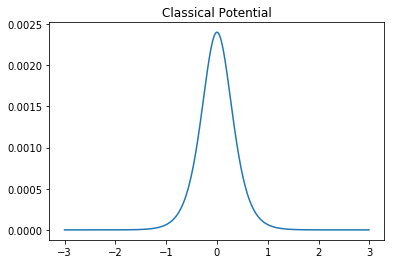

In [76]:
plot(arange(-3,3,0.01,config.floatX), V_(arange(-3,3,0.01,config.floatX)))
title('Classical Potential')
show()

#### Classical Force ####

In [77]:
# symbolic gradient
Fx = fun(x) (-grad(V(x),x))

In [78]:
Fx_ = function([xv],Fx(xv))

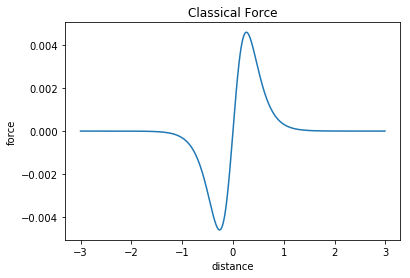

In [79]:
plot(arange(-3,3,0.01,config.floatX), Fx_(arange(-3,3,0.01,config.floatX)))
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

In [80]:
D_ = function([C],debound(1/J(C).determinant()))

### Initial Data ###

In order to compute the quantum force on the particles in world $n$ we introduce four widely separated fictitious particles in worlds to the left and right to represent open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [181]:
N = 5000

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [182]:
from sympy import Abs, Symbol,pi as Pi, I, exp as Exp, integrate, oo, solve, Eq
x = Symbol("x", real=True)
alpha = Symbol("alpha", positive=True)
x0 = Symbol("x0", real=True)
m = Symbol("m", real=True)
v = Symbol("v", real=True)
x1 = Symbol("x1", real=True)
y1 = Symbol("y1", real=True)
model1={m:2000,alpha:0.70,v:0.00164317,x0:-7.0}
Wx=Abs((alpha/Pi)**(1/4)*Exp(-(alpha/2)*(x-x0)**2)*Exp(I*m*v*x))**2
Wx

                       2
 -0.5  0.5  -α⋅(x - x₀) 
π    ⋅α   ⋅ℯ            

In [183]:
Wx.subs(model1)

                                       2
                   -0.5  -0.7⋅(x + 7.0) 
0.836660026534076⋅π    ⋅ℯ               

In [184]:
W=theano_function([x],[Wx.subs(model1)], dims={x: 1}, dtypes={x: config.floatX})

We may compute a monotonic uniformizing mapping into this distribution by inverting the cummulative distribution.

In [185]:
cumWx = integrate(Wx,(x,-oo,x1)); cumWx

erf(√α⋅(-x₀ + x₁))   1
────────────────── + ─
        2            2

In [186]:
erfinv0=solve(Eq(y1,cumWx),x1)[0]
erfinv0

     erfinv(-2⋅y₁ + 1)
x₀ - ─────────────────
             √α       

In [187]:
erfinv0.subs(model1)

-1.19522860933439⋅erfinv(-2⋅y₁ + 1) - 7.0

In [188]:
erfinv1=theano_function([y1],[erfinv0.subs(model1)], dims={y1: 1}, dtypes={y1: config.floatX})

In [189]:
crosses=fun(C)(min([debound(d(-1,C[j],0)) for j in dim])<=0)

In [190]:
b0 = erfinv1(grid(1,N+2*B)[0]); b0[0] -= 1e12; b0[1] -= 1e6; b0[-2] += 1e6; b0[-1] += 1e12

In [191]:
b0[:4],b0[-4:]

(array([ -1.00000000e+12,  -1.00000990e+06,  -9.78119281e+00,
         -9.70016800e+00]),
 array([ -4.29983200e+00,  -4.21880719e+00,   9.99995900e+05,
          1.00000000e+12]))

In [192]:
crosses(array([b0])).eval()

array(False, dtype=bool)

After adding the open boundary conditions, we can check the accuracy by comparing the discrete representation to the original distribution.

In [193]:
p0 = debound(b0)

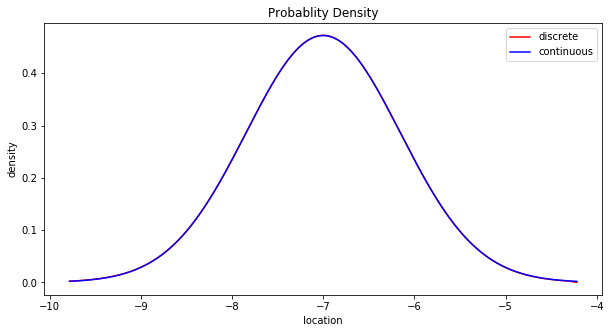

In [194]:
figure(figsize=(10,5))
plot(p0, debound(1.0/N/d(-1,b0,0).eval()), color='red',label='discrete')
plot(p0, W(p0), color='blue',label='continuous')
legend()
title('Probablity Density')
xlabel('location'); ylabel('density')
show()

#### Distribution of Velocity ####
The particles have an identical initial velocity in each world of

In [195]:
v0=boundary0(full(N,v.subs(model1),config.floatX)).eval(); v0

array([ 0.        ,  0.        ,  0.00164317, ...,  0.00164317,
        0.        ,  0.        ])

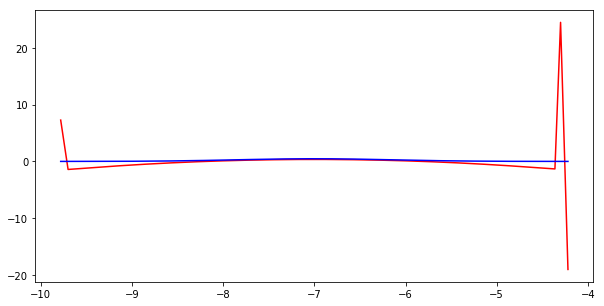

In [196]:
figure(figsize=(10,5))
plot(p0, Q_(1,[1],[b0]), color='red')
plot(p0, W(p0), color='blue')
show()

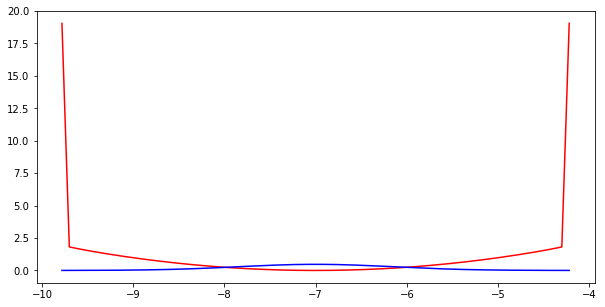

In [197]:
figure(figsize=(10,5))
plot(p0, Q2_(1,[1],[b0]), color='red')
plot(p0, W(p0), color='blue')
show()

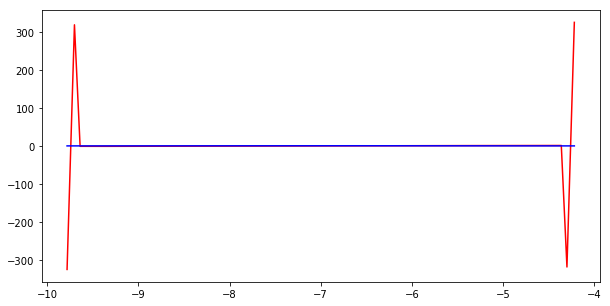

In [198]:
figure(figsize=(10,5))
plot(p0, R_(1,[1],[b0])[0], color='red')
plot(p0, W(p0), color='blue')
show()

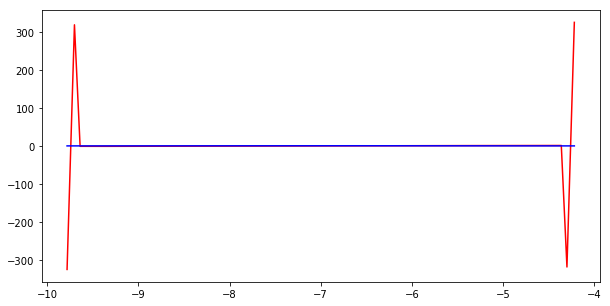

In [199]:
figure(figsize=(10,5))
plot(p0, R3a_(1,[1],[b0])[0], color='red')
plot(p0, W(p0), color='blue')
show()

#### Acceleration ####

In [200]:
def A(hbar,mu,x):
    #debound(clone(theano_code(r2),ro,strict=False))
    return boundary0((1/mu[0])*(Fx(x[B:-B]) + R2a(hbar,mu,stack([x]))[0]))

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [201]:
def G(a,v):
    alpha = 0.0 # 0.05 # sensitivity
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v*v)
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [202]:
mu = array([2000.0])  # mass
hbar = 1.0  # Planck's constant

In [203]:
rho = shared(asarray(1.0, config.floatX))
ds = scalar()
dt = ds/rho
t = shared(asarray(0.0, config.floatX))
x = shared(b0)

In [204]:
a0 = A(hbar,mu,x).eval()

In [205]:
a = shared(a0)
v = shared(v0)
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [206]:
VerletStep = function([ds],t, updates=[
    (rho, rho + G(a,v)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
],allow_input_downcast=True)

#### Energy ####

In [207]:
KU1 = 0.5*mu[0]*sum(v[B:-B]*v[B:-B])  # total kinetic energy
PU1 = sum(V(x[B:-B]))             # total classical potential
QU1 = sum(Q2a(hbar,mu,stack([x])))            # total quantum potential
E_ = function([],[KU1,PU1,QU1])

In [208]:
E_()

[array(13.500038244500788),
 array(4.353573135252059e-11),
 array(0.4504935223422347)]

In [209]:
crossing=function([],crosses(stack([x])))

In [218]:
t_start = 0.0; t_end = 10000.0;

t_samples = 100; x_samples = 100
t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))+B
XS = array(range(x_start,N-x_start-1,x_sample))

ds0 = 0.05*1000**2/N**2 # N=1000 # initial step size
#ds0 = 0.01 # N=1000 # initial step size
#ds0 =  0.00008 # 0.0000001 # N=10000
#ds0 =  0.0000008 # 0.0000001 # N=100000
dsn = 1 # initial step size divider

In [219]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho0 = 1.0
        rho.set_value(rho0)
        t.set_value(t_start)
        x.set_value(b0)
        v.set_value(v0)
        a.set_value(a0)
        # recording
        T = [t_start]
        Rho = select({t_start:rho.get_value().item()})
        XX = select({t_start:x.get_value()[XS]})
        XV = select({t_start:v.get_value()[XS]})
        [KK,PP,QQ] = E_()
        E1 = KK+PP+QQ  # total energy
        TK = select({t_start:KK})
        TP = select({t_start:PP})
        TQ = select({t_start:QQ})
        E = select({t_start:E1})
        
        try:
            t0 = t_start
            while t0<t_end:
                t1 = t0 + t_sample
                while t0<t1:
                    rho0 = rho.get_value().item()
                    if rho0 > 100 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                    t0 = VerletStep(ds).item()
                # Check no-crossing
                if crossing()<0:
                    raise ValueError("crossing at %s",t)
                # Check total energy conservation
                [KK,PP,QQ] = E_()
                E2 = KK+PP+QQ
                print "t =", t0, "t1 =",t1,"rho =", rho0, "E1-E2 =",E1-E2
                sys.stdout.flush()
                if abs(E1-E2)/N>1e-10:
                    raise ValueError(
                        "Energy conservation bound failed at %s. Delta E:"\
                        "|%s|/N > 1e-10."%(t0,E1-E2))
                E1 = E2
                T += [t0]; XX[t0] = x.get_value()[XS]; XV[t0] = v.get_value()[XS]
                Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
                #t0 = t.get_value().item()
        except KeyboardInterrupt:
            print "Interrupted at %s ..."%(t0)
            T += [t0]; XX[t0] = x.get_value()[XS]; XV[t0] = v.get_value()[XS]
            Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
        tmax = t0
        break
    except ValueError as msg:
        print msg
        dsn = dsn + 1
        print "Trying a shorter initial step size: %s."%(ds0/dsn)
        #continue
T=array(T)
print "t =", tmax

t = 100.0 t1 = 100.0 rho = 1.0 E1-E2 = nan
Interrupted at 115.047 ...
t = 115.047


Step Density

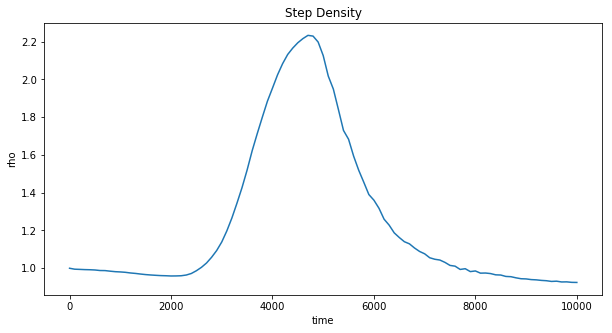

In [288]:
figure(figsize=(10,5))
plot(T, Rho[T])
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

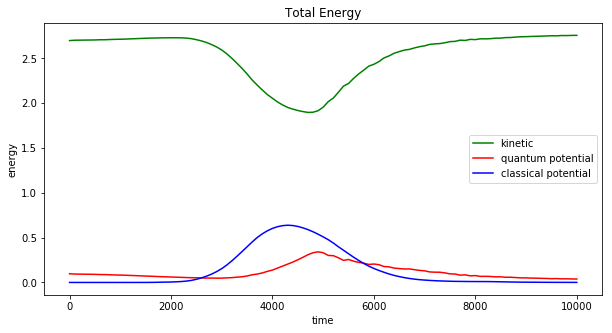

In [289]:
figure(figsize=(10,5))
plot(T, TK[T],color='green',label='kinetic')
plot(T, TQ[T],color='red',label='quantum potential')
plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

#### Energy Conservation ####

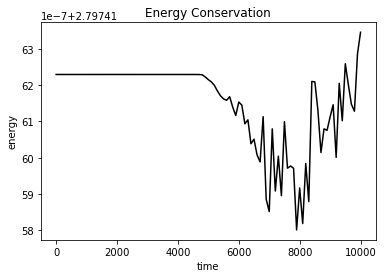

In [290]:
plot(T, E[T],color='black')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

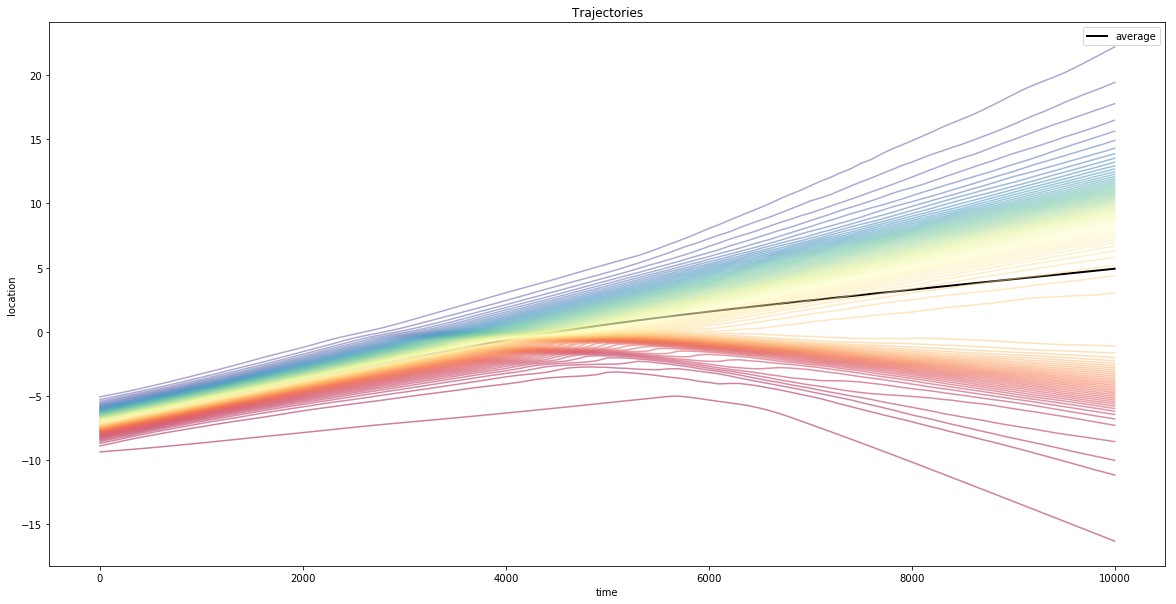

In [291]:
figure(figsize=(20,10))
plot(T, mean(XX[T],1), color='black',label='average',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(len(XS)):
    plot(T, XX[T][:,i],color=line_color[i],alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

#### Final Distribution ####
The distribution at the end of the simulation shows the reflected and transmitted "wave packets" separating from each other.

In [292]:
fig = figure(figsize=(10,5))
ax = axes()
ax.set_xlim(( -10, 15))
ax.set_ylim((0, 0.5))
line, = ax.plot([], [], lw=2)
def animate(t):
    line.set_data(XX[t][B:-B],D_([XX[t]])/x_samples)
    return (line,)
ani=animation.FuncAnimation(fig, animate, frames=T, interval=100, blit=True)
close()
HTML(ani.to_html5_video())

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAELoW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTQ4IHIyNzQ4IDk3ZWFlZjIgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE2IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAzOZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMB+8C/gSCcz9Z0IAAAAwNIpHne
sZRf3mAT8BMm1K95fl5PkJWL/GH7gLq47a6N79N51JJt9NIMEakqYnGN+r4iLNOH5KzITyAWplLD
RRg59sQJBK68uS+lrd4dYAaZktjjM2cEGBXjTKdbmFojFvqfb/9jf9KKxnPJ0kmNPM5P75gtlqd5
NEs2Y/6oKVMF8+j5KWr6gdurpG3iUVFm+o+PhFvb5490LVYc6igHQUU2KbuDhYt+xXWYEqP4hkeO
8AWs/qhJVt1/MZ6vMWATp0l53yYt8soE9xYDlkW+iJsVmeRyBMzPFYR1ULPxzUBqV6Vp6UyEdH6F
fIwrVFUVuhhhMIZEcpKm9cMPCUTvm2xJnfHeMI1+LLpyUFFl72tvDDozd1PIq3xFokpW+Uk2VYbx
YQ47e6yqAAkhRfeGCxMLnS4ix2BRgOkfwQt7fS9S6cZ8iRsLwuHT/geg2lK7CBrPFSBVmNPbb16E
pM23geR4R5SsdBfkpX6cLzXkKQRogipdOVlBbAmFdCq1NDIs5Fcs/pWcLbK2liwkbJdYjFSYvjXq
+WZtHPz7AtO6HvHb5rYwWaxZQ3v6E6leniwErw1cqXvtLqTYVdBO2RuaQ31ORxPki+dQPwadHoWG
Ox+oMfRzPRYqdndf7yRLVF/Vy4GEXymaWBGGgcQgfFei01OaOVacP6TL+DiPccymzYYAD8W7kbWE
sV58y7PwO2d6uWlJ6mLP1UpFDDl7sgBgaLgCG+yDFA1dc+Fs0ZMC6Z2sZUmCvYEnM9QF5sqCreiV
Cbwh/l+TQ1/2fwrKLp7OFYlBb5ABd70xT+hZ6y0PJOlejQWyn79XcMlNnHyuQQHYUTul3LgR1nMV
ReV6wHD0iMVmPFKhwbdstuq/E4ki90hdJHnSy2R33nfTPAPrFoaM+wTFSnfw0x8bC4/NRR9OYxBD
wYqLzULTPeW2T9yZNy7FoNEVRwaTFx6ROfeN1tHC2g9FEKZs98BohWxb2bSI7oGnJ6DJeMRk9ys4
hlYMrWnuU9gt0IjCtheKVFxyxvoY4PLo2v4fxdHdV7qjT0CPDcNHv5dgI/r7fVnQCVuebUr4sAQ3
yWHgoL3qcFKNBiBHlYurEq/d96hP0E50IEdhDMf0yAHf17FSm6yLl8kH/D1RH89UuRCcqT3CN8fJ
/4nzpXOsjw5+qQ8lzZ5QTmsv1siup3nDAwoJewjHCIwq9AUkGr/NX+P/qYTzavEereDqWKjoymHL
WBQIqiJSC30kElXghIQDhl/ZapvuuC3VwWQe944TviOGsBLhwZJ0DM0epzUYbeRD1Vi15UD5OGa/
15apkkelSnq7yWhKYonG+kvYRyxej1XoAF+uyjT1gzG9h7xi7j/WXFTrdfrY0MWkW/wKOvI4EGap
p5RZNOq7HcQrkLM1xWIrq8qZg4N302eh0rvy/BkROclRjxVX78Gszii88PeOiO2NpXXeY4a2Yi7k
YFYWOnijPrMLtyVF3L8CVhQ98emZwXx9nSDdmwouKv2QEDeq9g9xhMNwotRs+Q2KHrFw7mNqBaTL
ynPayExHOIQzgJi0FM5NAmSksfV+iEw044szH4az7JCFev3k2HOGAiSawFaLah07Bjc4A/bANiu+
/w2uofV1U55gRN5OV4ZMzrdAVJfNEpddm+iajPU0drodl7Kml1WHA3eB4TMOqkF8vR+Q4cmctEyD
0TSk6efIYXqKAf/TrycuOq+4a/gQxd//HczZ4WByndPOfzDF58EpudkU+vUjqilSxdgtDHJ7cBrA
I/LlCN9KK106rJnO2oaASvCLzcIxFeH3O7FOiz4PaJ3i4jSmw5dVWlgCVr2F97mziSTRSN5C695P
li9o/zXGHqJI/QwFPcgHxpcArC5Xmn1NqlERtbB8gq5FFL71oJ1pSoWQtTLY3fuc4R+JZSCm99kz
pWXSaBNPh31N4D/Mt9I77vxz0Dz4MQW8Iw5SAQ3UVo6NZqO/QaR31cYHA2zOp4BjStW/NxokCAU7
+V2GTNzzByMERwfgzyfpEaYCkzn/lmRWIiRvanrmHlukfkYHusFd8n/nEUagAGU45Jp1NZ1UE+r0
Fa0mXJet82hmxySrGfNnmSo2FOOctmXeyjlm/CHKVCA2Z++LuaPswAKdQMTepu8uPguDim6r0bjK
T8fD4cp/QZ8kY1uK6DdMQzl1JCfN9X/rfttG488M/dqbNo4SiUBYSmT7fS0DArNwiIfJlaIGoX1Y
z4e1tiIZiETWxnba+dtHa9hzkgGdehw2Jod10+Baf877KAv8oZO0yi+AOL25NKZ8UpItfkn2RxnT
AGey0V7P/Ymf1X8lgUh25vY6mVMzItR6YlSBncw4lILDKWDseyeedcduKFaM6ssngRfiuGY0/fLW
EKk7Box4ABFk5FAY3+x5zdEovmtJTx4SOZ6fK49kpLKx+wLuGtWRGpGS9Jcavz0MaH3/abGsxc/b
0ib3EbIAa3yhqqM1WFlQOcA/BRE6wdOv6rXNByF0RiIgYDox3P15DBrbOa3ZiBJbnlVTQxM5Xf9s
veMRFXqcwrgK+y1JsvSw6wBvmhM+nekb7ZDGO59ed9NXquR/pIkTWLJX1Ku/xlO/0bIfNOrSr7hS
/eVEuBUNoe9AO1LKOLp7U2EtSK7KwXy01SzwybQuRyF2GnMxO9LYLBUDVuO2BnF+p9gtCdJrPoks
MwUFCJ5bHcdYknj7EnKXI5JVmWl4SrwyF5KydUB6gr3kH+QqXFRWeG2XgCuPH93uIPfM+DGlMJbS
Uzde0xi0mcVukLNswYeHGbQRUiVnkZDPI8UBtf4XmAEi8pg0z5g/MVPFbF72ubX30JxRRlAgiiD5
LVanpPClop5nHylmq/znZ

In greater detail ...

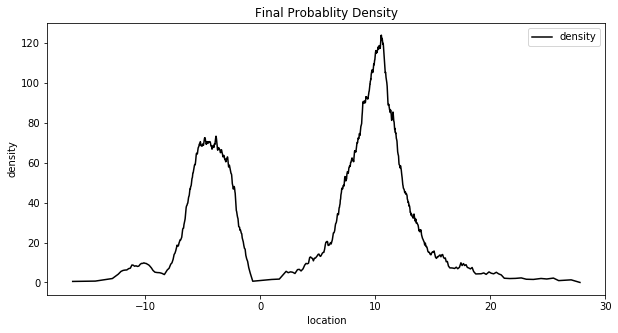

In [293]:
figure(figsize=(10,5))
plot(x.get_value()[B:-B],debound(1.0/d(-1,x.get_value(),0)).eval(),color='black',label='density')
legend()
title('Final Probablity Density')
xlabel('location'); ylabel('density')
show()

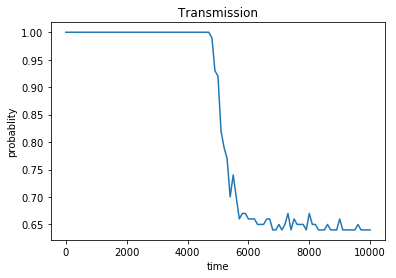

In [294]:
plot(T, mean(select(XV)[T]>0,1))
title('Transmission')
xlabel('time'); ylabel('probablity')
show()

Final transmission probability

In [295]:
print '%.4f'%(v.get_value()>0).mean()

0.6444
